<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/find_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 439 (delta 41), reused 2 (delta 2), pack-reused 366
Receiving objects: 100% (439/439), 47.70 MiB | 20.96 MiB/s, done.
Resolving deltas: 100% (255/255), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [13]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel, CustomCategoricalCrossentropy

# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:
# Data Source
data_loader = DataLoader()

project_data, variable_types  = data_loader.load_2017()


# Vectorizing the data set

In [10]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)


In [11]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.keras"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.keras"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


model = load_model(local_model_path)

## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

In [ ]:
# reconstruct the original data
predicted = pd.DataFrame(model.predict(vectorized_df))
predicted.columns = vectorized_df.columns
predicted


In [18]:
attr_cardinalities = list(project_data.describe().T['unique'].values)
ccce = CustomCategoricalCrossentropy(attribute_cardinalities=attr_cardinalities)

In [25]:
# compute the error between the reconstructed data and the original data
custom_loss = ccce.call(vectorized_df.to_numpy(),predicted.to_numpy())
mae_loss = tf.losses.mae(vectorized_df,predicted)
mse_loss = tf.losses.mse(vectorized_df,predicted)
cce_loss = tf.losses.categorical_crossentropy(vectorized_df,predicted)

In [27]:
errors = pd.DataFrame()
errors['custom_error'] = custom_loss
errors['custom_rank'] = errors['custom_error'].rank(pct=True)
errors['mae_error'] = mae_loss
errors['mae_rank'] = errors['mae_error'].rank(pct=True)
errors['mse_error'] = mse_loss
errors['mse_rank'] = errors['mse_error'].rank(pct=True)
errors['cce_error'] = cce_loss
errors['cce_rank'] = errors['cce_error'].rank(pct=True)

errors['error_rank'] = (errors['custom_rank'] + errors['cce_rank'] + errors['mse_rank'] + errors['mae_rank']) / 4



<Axes: xlabel='custom_rank', ylabel='mse_rank'>

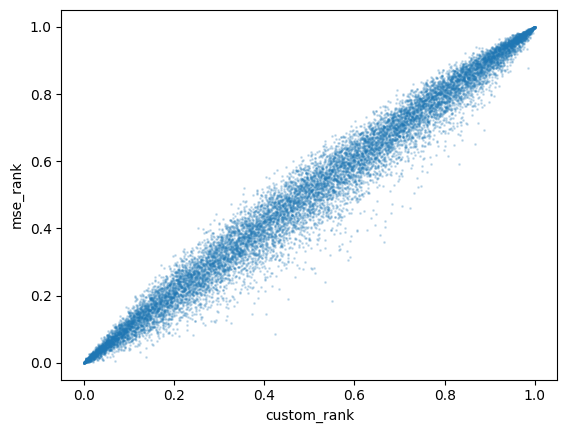

In [31]:
errors.plot(kind='scatter', x='custom_rank', y='mse_rank', s=1, alpha=0.2)

<Axes: xlabel='custom_rank', ylabel='cce_rank'>

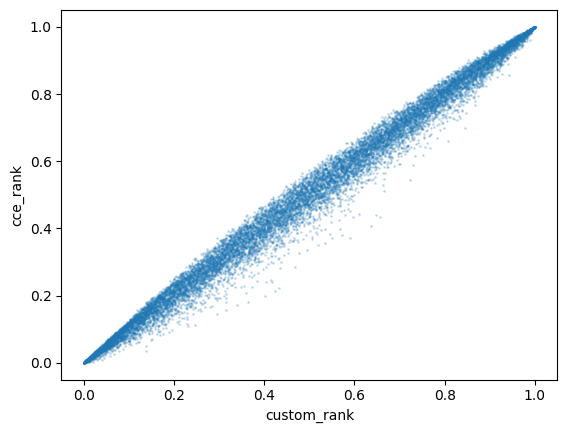

In [30]:
errors.plot(kind='scatter', x='custom_rank', y='cce_rank', s=1, alpha=0.2)

<Axes: xlabel='mae_rank', ylabel='custom_rank'>

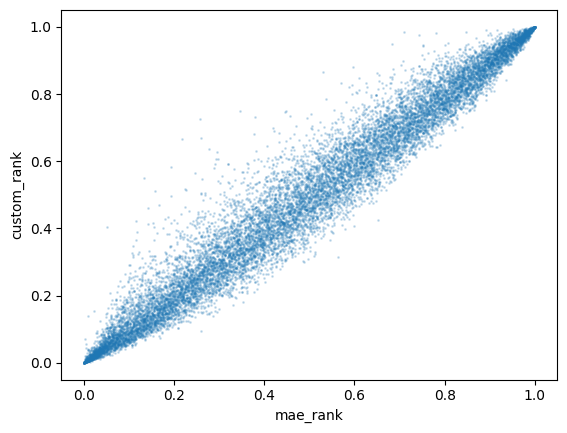

In [33]:
errors.plot(kind='scatter', x='mae_rank', y='custom_rank', s=1, alpha=0.2)

Obtain the indices in descending order of the reconstruction errors.

In [34]:
combined_df = pd.concat([vectorizer.tabularize_vector(vectorized_df), vectorizer.tabularize_vector(predicted), errors], axis=1)
combined_df = combined_df.sort_values('error_rank', ascending=False)

# Create a GCS filesystem object
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Define the path to the file on GCS
gcs_path = "gs://autoencoder_census_models/data_with_reconstructed_errors.csv"

# Save the DataFrame to GCS
with fs.open(gcs_path, 'w') as gcs_file:
    combined_df.to_csv(gcs_file)

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [35]:
combined_df.head(20)

,age,sex,grade,Hispanic_or_Latino,race,obese,overweight,sexual_identity,sex/sexual_contacts,sexid,...,bmipct_cat,custom_error,custom_rank,mae_error,mae_rank,mse_error,mse_rank,cce_error,cce_rank,error_rank
100,16 years old,nan,11th,Black or African American,Black or African American,nan,nan,Heterosexual (straight),Males,Heterosexual,...,missing,0.806967,1.000000,0.216840,1.000000,0.115637,1.000000,593.032104,1.000000,1.000000
7757,14 years old,Female,9th,All other races,Asian,nan,nan,Gay or lesbian,Females,Gay or Lesbian,...,missing,0.768707,0.999865,0.213092,0.999932,0.109196,0.999932,588.976318,0.999865,0.999898
6848,18 years old or older,Male,11th,Black or African American,Black or African American,obese,not overweight,Not sure,nan,Not Sure,...,normal,0.781711,0.999932,0.205603,0.999729,0.108340,0.999865,587.651733,0.999797,0.999831
7242,12 years old or younger,Female,12th,Hispanic/Latino,Hispanic/Latino,nan,nan,Bisexual,Males,Bisexual,...,missing,0.762937,0.999729,0.205574,0.999661,0.105912,0.999661,589.499023,0.999932,0.999746
3969,16 years old,Male,9th,All other races,Am Indian / Alaska Native,nan,nan,Bisexual,nan,Bisexual,...,missing,0.762254,0.999661,0.206458,0.999797,0.105946,0.999729,586.440918,0.999594,0.999695
10829,16 years old,Female,10th,White,White,obese,not overweight,nan,Females,nan,...,normal,0.750466,0.999526,0.206530,0.999865,0.106351,0.999797,584.097778,0.999458,0.999661
147,12 years old or younger,Male,nan,White,White,not obese,overweight,Not sure,Females,Not Sure,...,normal,0.753772,0.999594,0.203213,0.999526,0.105647,0.999594,586.724609,0.999729,0.999611
6313,18 years old or older,Male,12th,Black or African American,Black or African American,nan,nan,Gay or lesbian,Females,Gay or Lesbian,...,missing,0.766568,0.999797,0.197386,0.999255,0.104986,0.999526,586.591553,0.999661,0.999560
120,18 years old or older,nan,11th,nan,nan,nan,nan,Bisexual,Females,Bisexual,...,missing,0.734263,0.999187,0.203965,0.999594,0.103746,0.999390,582.025757,0.999390,0.999390
5390,17 years old,Male,12th,Black or African American,Black or African American,not obese,not overweight,Gay or lesbian,Females,Gay or Lesbian,...,normal,0.739624,0.999323,0.196245,0.999120,0.102487,0.999255,586.192993,0.999526,0.999306


In [ ]:
vectorizer.tabularize_vector(vectorized_df), vectorizer.tabularize_vector(predicted)

In [42]:
t = combined_df.query("error_rank > 0.99")['ever_heroin_use']
t.columns = ['correct', 'predicted']
t.correct.value_counts()


0 times             61
40 or more times    18
1 or 2 times        16
3 to 9 times        14
10 to 19 times      12
20 to 39 times      10
nan                 10
Name: correct, dtype: int64

In [45]:
t.predicted.value_counts()

0 times             14209
nan                   319
40 or more times       80
1 or 2 times           10
3 to 9 times            4
20 to 39 times          2
Name: predicted, dtype: int64

In [44]:
t = combined_df.query("error_rank < 0.99")['ever_heroin_use']
t.columns = ['correct', 'predicted']
t.correct.value_counts()

0 times             14026
nan                   375
1 or 2 times           86
40 or more times       74
3 to 9 times           37
10 to 19 times         17
20 to 39 times          9
Name: correct, dtype: int64

In [50]:
t = combined_df.query("error_rank > 0.99")['multiple_sex_partners']
t.columns = ['correct', 'predicted']
t.correct.value_counts()

nan                 57
6 or more people    34
3 people            17
1 person            12
4 people             7
2 people             6
Never had sex        4
5 people             4
Name: correct, dtype: int64

In [51]:
t = combined_df.query("error_rank < 0.99")['multiple_sex_partners']
t.columns = ['correct', 'predicted']
t.correct.value_counts()

Never had sex       8035
1 person            2159
nan                 1530
2 people            1069
6 or more people     626
3 people             615
4 people             373
5 people             217
Name: correct, dtype: int64